In [3]:
#Для подавления предупреждений о недостаточной сходимости можно использовать:
import warnings

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

from sklearn import model_selection
import numpy as np

In [5]:
from sklearn.linear_model import LogisticRegression as LR

In [6]:
clf = LR()

In [7]:
#Рекоммендуемая реализация LogLoss
def log_loss(pred, y): return -np.sum(y*np.log2(pred)+(1-y)*np.log2(1-pred))/len(y)

In [8]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
def get_error(pred, y):
    return np.sum((pred != y).astype(int)) / len(y)

In [9]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)


    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):

        clf = LR()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            clf.fit(X, y, w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[np.logical_not(match)] *= np.exp(alpha)
        w[match] *= np.exp(-alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

In [10]:
N = 50

models = adaboost(X_train, y_train, N)

In [11]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
        y_pred[range(n_objects), (~prediction)] -= alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 92.254


In [12]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 90.909


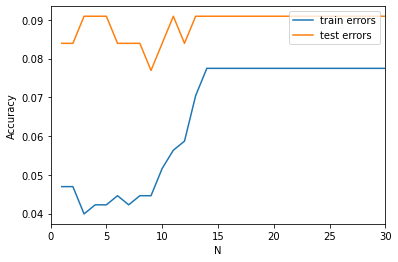

In [13]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')